In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from models.video_classifier import TransformerModel
from utils.utils import train_model, evaluate_model_with_cm, TiffDataset, compute_and_visualize_avg_attention, evaluate_perturbation, plot_importance_maps
import os
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
val_filter = lambda x: x >= 1 and (x % 50) in {1, 6, 13, 18, 25, 30, 32, 37, 44, 49}

In [4]:
bands = 4
patch_size = 3
num_epochs = 100

os.makedirs("./checkpoints/patch_size_test", exist_ok=True) #checkpoints 저장할 dir
large_tif_dir = '../../data/source_data/naive' #원천데이터 주소

class ReshapeTransform:
    """(12*bands, 3, 3) → (12, bands, 3, 3) 변환"""
    def __init__(self, bands, patch_size):
        self.bands = bands
        self.patch_size = patch_size
    def __call__(self, x):
        return x.view(12, self.bands, self.patch_size, self.patch_size).permute(1, 0, 2, 3)

def get_transform(bands, patch_size, scale_channels_func=None):
    transform_list = [
        transforms.ToTensor(),  # (H, W, C) → (C, H, W)
        transforms.Lambda(lambda x: x.float()),  # uint16 → float 변환
        ReshapeTransform(bands, patch_size)  # (12*bands, 3, 3) → (bands, 12, 3, 3)
    ]

    if scale_channels_func:
        transform_list.append(transforms.Lambda(scale_channels_func))  # 채널별 값 조정 추가

    return transforms.Compose(transform_list)

#scaling 함수 - 채널별로 범위의 차이가 크기때문에 어느정도 맞추어주기 위해서 수행
def scale_channels(x):
    """특정 채널값 조정"""
    x[0:3] *= 5  # B,G,R 채널 * 5
    if 4 < x.shape[0]:
        x[4] *= 0.5  # NDVI 채널 * 0.5
    return x

transform = get_transform(bands, patch_size, scale_channels)

train_dataset = TiffDataset(
            large_tif_dir = large_tif_dir,
            file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
            label_file = "../../data/label_data/species/label_mapping_sampled.csv",
            box_filter_fn = lambda box_number: not val_filter(box_number),
            patch_size = patch_size,
            transform=transform
        )

val_dataset = TiffDataset(
            large_tif_dir = large_tif_dir,
            file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
            label_file ="../../data/label_data/species/label_mapping_sampled.csv",
            box_filter_fn = val_filter,
            patch_size = patch_size,
            transform=transform
        )

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [5]:
d_model = 8*(patch_size+7)
model = TransformerModel(patch_size=patch_size, d_model=d_model).to(device)
model.load_state_dict(torch.load(f"./checkpoints/patch_size_test/transformer_new_{bands}_{patch_size}_{num_epochs}.pth"))

<All keys matched successfully>

Processing Batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3796/3796 [00:38<00:00, 98.13batch/s]


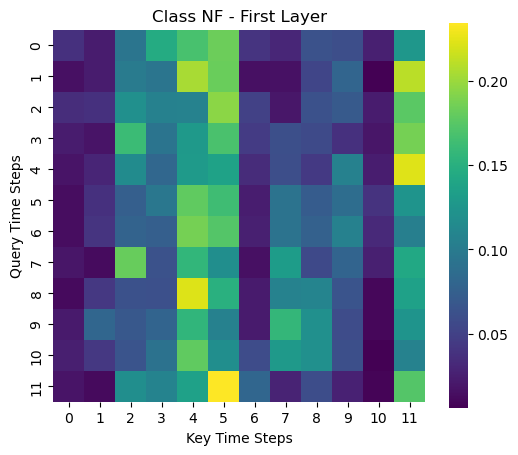

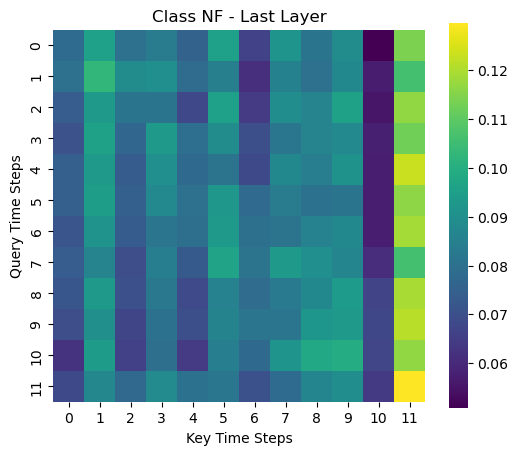

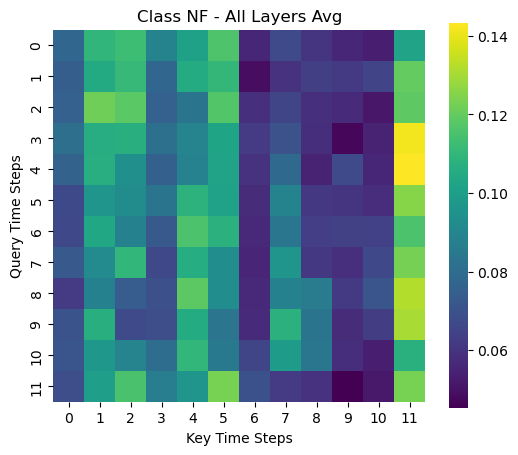

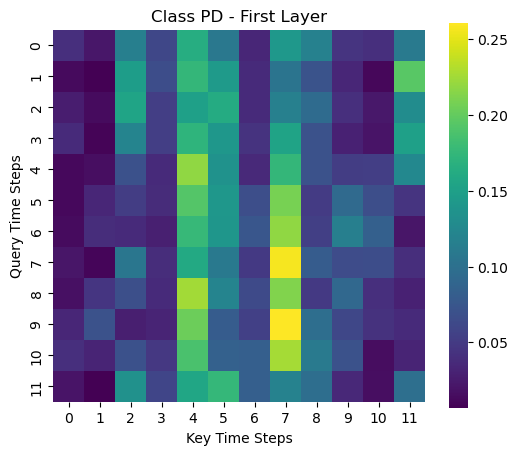

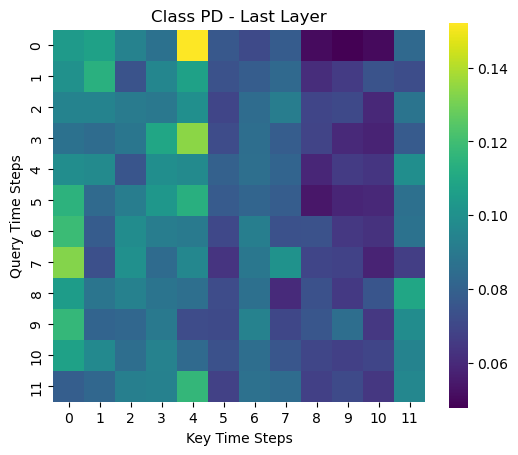

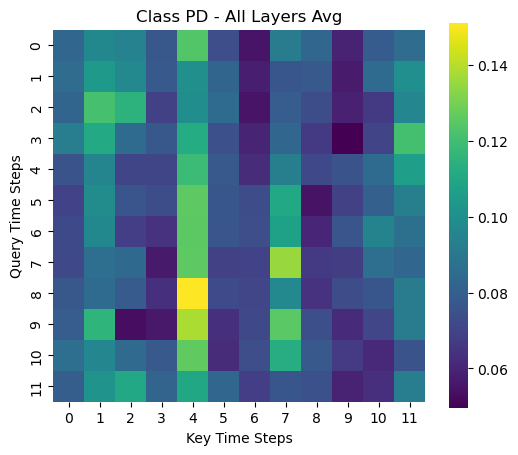

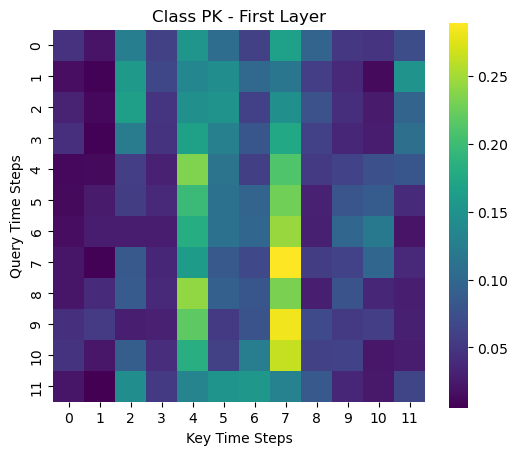

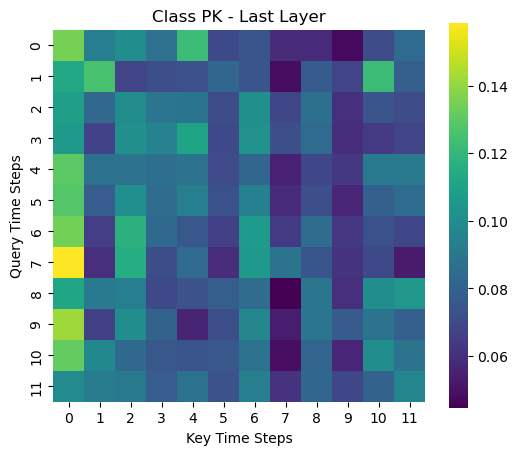

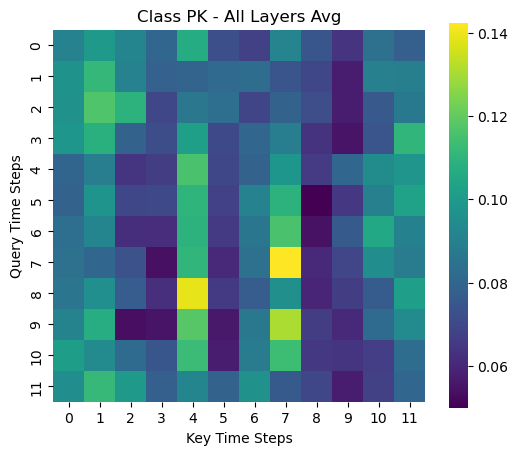

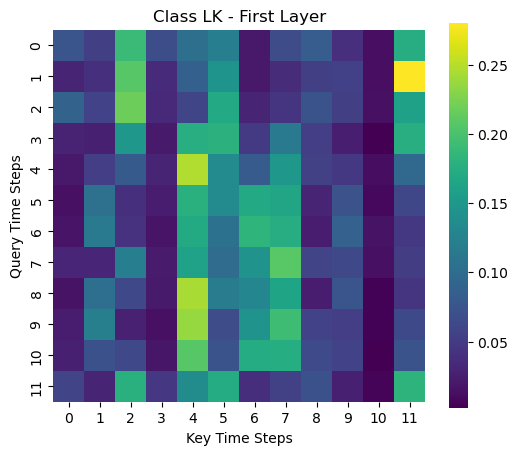

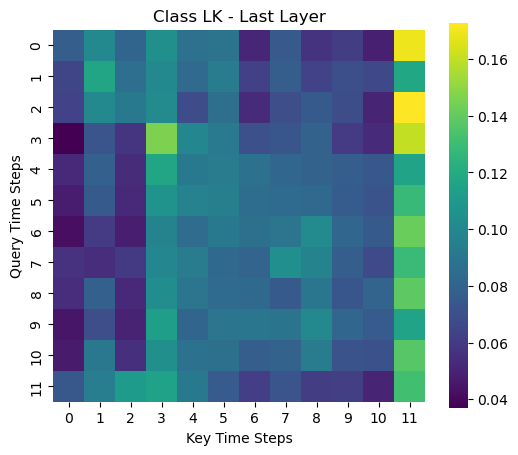

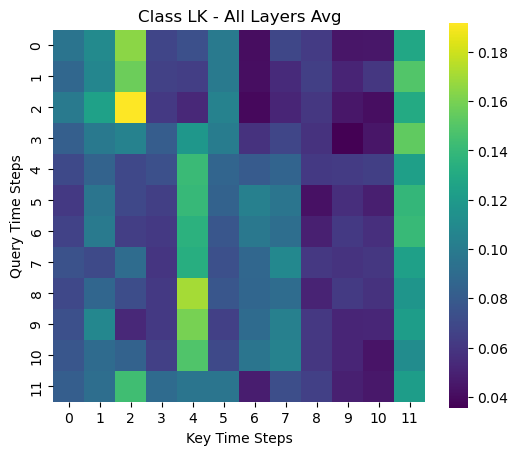

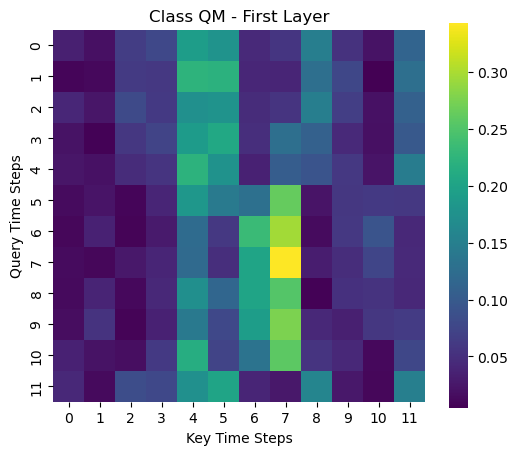

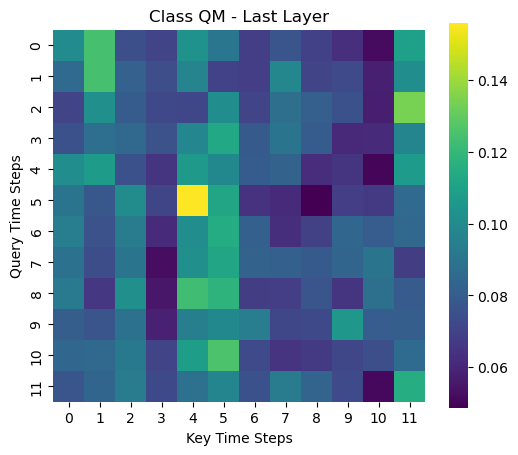

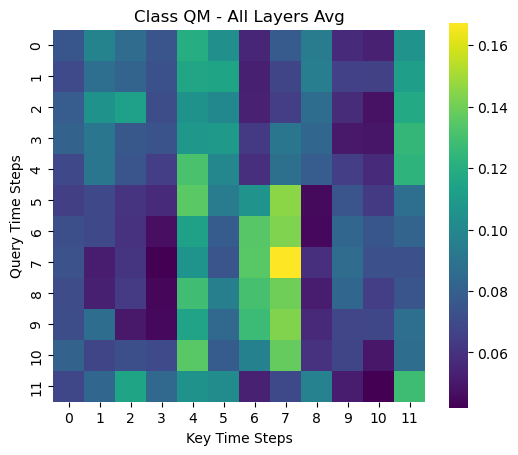

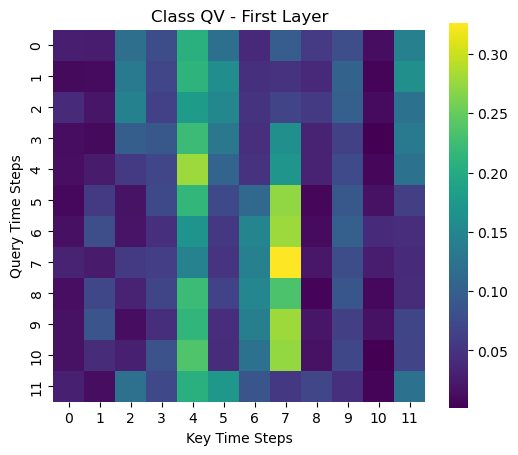

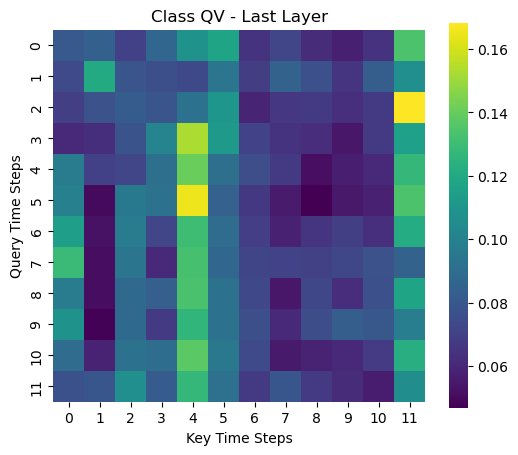

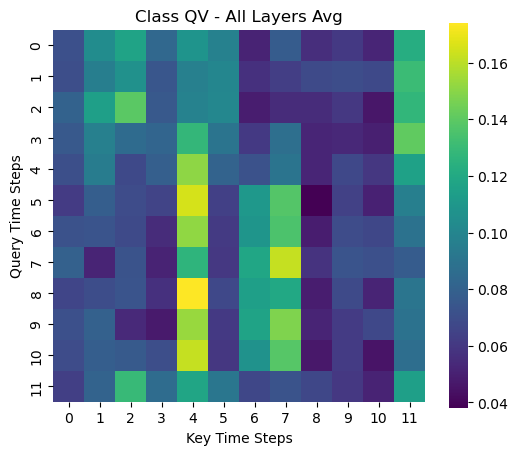

✅ 18 개의 평균 Attention Map이 출력되었습니다.


In [6]:
compute_and_visualize_avg_attention(model, train_loader, num_classes=6, device=torch.device("cuda"))

In [ ]:
importance_maps, band_importance, time_importance  = evaluate_perturbation(model, train_loader, num_classes=6, noise_level=1.0, num_repeats=3)
plot_importance_maps(importance_maps, band_importance, time_importance)

Experiment 3/3:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 3294/3796 [12:34<02:01,  4.13it/s]